# Sheet 8

In [1]:
import os
import numpy as np
import torch
from torch import nn
import torch.utils.data
from matplotlib import pyplot as plt
from tqdm import tqdm

## 1) Anomaly detection for Autoencoders

In [2]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
#import wget
#from zipfile import ZipFile
#from tqdm import tqdm

#DESTINATION = "data06"
#url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
#filename = "toptagging-short.zip"
#url = url + filename

#os.makedirs(DESTINATION, exist_ok=True)
#os.chdir(DESTINATION)
#wget.download(url, filename)
#with ZipFile(filename, "r") as zip_ref:
#    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
#        zip_ref.extract(member=file)
#os.chdir("..")
%ls data06

toptagging-short/  toptagging-short.zip


In [3]:
# Loading Data
X_train = np.load( "data06/toptagging-short/x_train_short.npy")
y_train = np.load( "data06/toptagging-short/y_train_short.npy")
X_test = np.load( "data06/toptagging-short/x_test_short.npy")
y_test = np.load( "data06/toptagging-short/y_test_short.npy")
X_val = np.load( "data06/toptagging-short/x_val_short.npy")
y_val = np.load( "data06/toptagging-short/y_val_short.npy")

print(f"train data shape: {X_train.shape}")
print(f"train labels shape: {y_train.shape}")
print(f"test data shape: {X_test.shape}")
print(f"test labels shape: {y_test.shape}")
print(f"val data shape: {X_val.shape}")
print(f"val labels shape: {y_val.shape}")

train data shape: (30000, 200, 4)
train labels shape: (30000,)
test data shape: (30000, 200, 4)
test labels shape: (30000,)
val data shape: (30000, 200, 4)
val labels shape: (30000,)


In [4]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)
    
    print( "Calculating eta" )
    etas  = eta(pT,pzs)
    
    print( "Calculating phi" )
    phis  = phi(pxs,pys)
    
    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)
    
    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)
    
    #return z_ori
        
    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum
    
    print( "Reshaping" )
    z_out = z_new.reshape( (z_new.shape[0],-1) ).reshape(-1, 1, 40,40)
    
    return z_out

In [5]:
class dataset_manipulator( torch.utils.data.Dataset ):
    
    def __init__( self, imgs, labels ):
        self.imgs = imgs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]

In [6]:
# Processing data
z_train = constit_to_img( X_train, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )
print(z_train.shape)
print(z_val.shape)
print(z_test.shape)

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
(30000, 1, 40, 40)
(30000, 1, 40, 40)
(30000, 1, 40, 40)


(a) Autoencoder

The Autoencoder below is built out of two different Multi Layer Perceptrons, the first one goes from 1600 to 10 neurons, while the second one expands the representation obtained from the other section growing back to the original size of 1600 pixels.<br>

In [7]:
# Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self, inner_rep_size=10):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(1600, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, inner_rep_size),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(inner_rep_size, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1600),
        )
    
    def forward(self, x):
        shape = x.shape
        x = x.flatten(1)
        x = self.encoder(x)
        x = self.decoder(x)
        return x.reshape(shape)

In [8]:
# Train autoencoder function used to train the autoencoder model
def train_autoencoder( model, dataloader, epochs = 10, learning_rate = 0.001 ):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam( model.parameters(), lr = learning_rate )
    losses = []

    for i in tqdm( range( epochs ) ):
        for x, y in dataloader:
            optimizer.zero_grad()
            outputs = model(x)
            loss = loss_function( outputs, x )
            loss.backward()
            optimizer.step()
            losses.append( loss.item() )
    return losses

(b) In this section we train the autoencoder just on QCD jets and the later we will show how the system is not quite able to recognize TOP jets in a test environment.

In [9]:
# Preprocess the QCD training data
qcd_train = z_train[ np.where( y_train == 0 ) ]
qcd_train_tensor = torch.tensor( qcd_train.astype( np.float32 ) )

# Generate the QCD training labels (we will not use these but we need them for the dataloader)
qcd_train_labels = y_train[ np.where( y_train == 0 ) ]
qcd_train_labels = torch.Tensor( qcd_train_labels.astype( np.float32 ) ).unsqueeze( -1 )

# Building the dataloader
train_dataset = dataset_manipulator( qcd_train_tensor, qcd_train_labels )
trn_dataloader = torch.utils.data.DataLoader( train_dataset, batch_size=30, shuffle=True )

model = Autoencoder(20)
epochs = 10
losses = train_autoencoder( model, trn_dataloader, epochs)

100%|██████████| 10/10 [00:54<00:00,  5.40s/it]


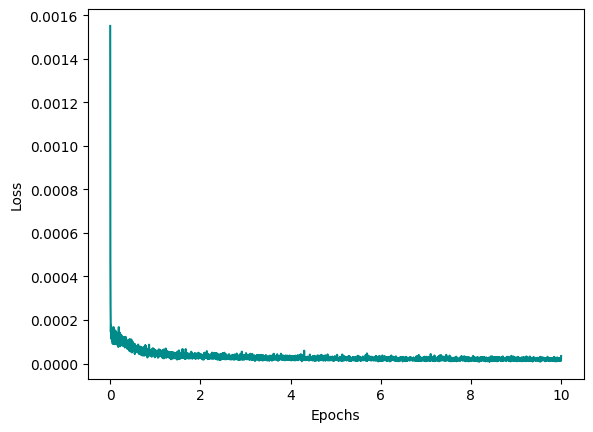

In [10]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( np.linspace(0,epochs,len(losses)),losses, c="darkcyan" )

In [11]:
# Test autoencoder function used to test the autoencoder model
def test_autoencoder( model, dataloader ):
    loss_function = nn.MSELoss()
    losses = []
    
    for x, y in dataloader:
        outputs = model(x)
        loss = loss_function( outputs, x )
        losses.append( loss.item() )

    return losses

In this section we will put the autoencoder trained just on QCD jets against a dataset containing both QCD and TOP jets, the idea is to prove that the model fails at representing correctly all of the features of a TOP jet coming out of the latent space. We used bigger batches to save some time.

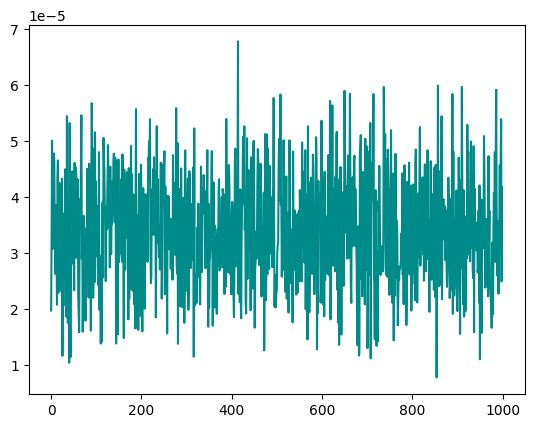

In [12]:
test_jets = torch.tensor(z_test.astype(np.float32))


test_jets_labels = torch.Tensor( y_test.astype(np.float32) ).unsqueeze( -1 )

test_dataset = dataset_manipulator( test_jets, test_jets_labels )
tst_dataloader = torch.utils.data.DataLoader( test_dataset, batch_size=30, shuffle=False )

losses = test_autoencoder(model, tst_dataloader)
plt.plot(losses, c="darkcyan")

(c)

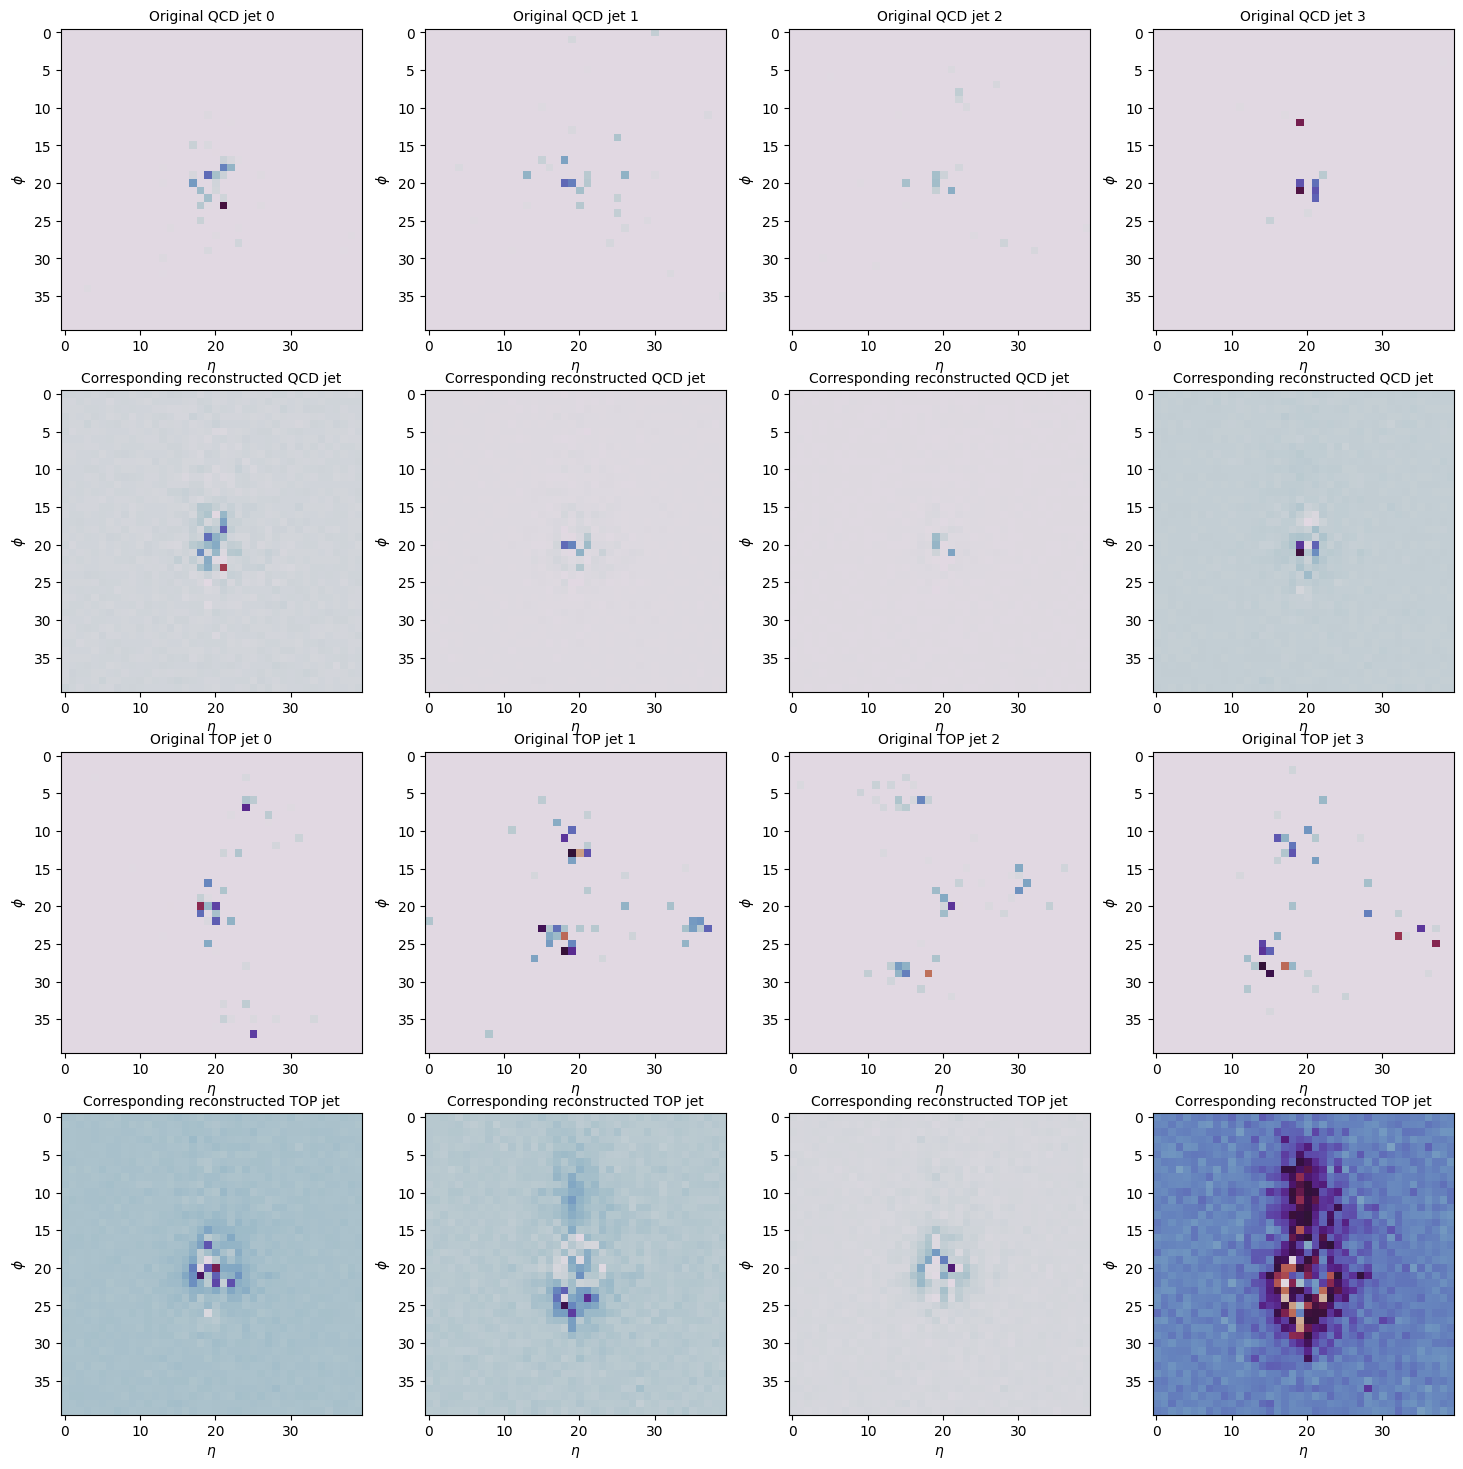

In [13]:
qcd_jets_val = torch.tensor(z_val.astype(np.float32))
top_jets_original = z_val[ np.where(y_val==1) ]
qcd_jets_original = z_val[ np.where(y_val==0) ]

pred = model(qcd_jets_val)
pred = pred.detach().numpy()

reconstructed_top_jets = pred[ np.where(y_val==1) ]
reconstructed_qcd_jets = pred[ np.where(y_val==0) ]

fig, axs = plt.subplots( 4, 4, figsize=(18,18) )

for i in range(4):
    axs[0, i].imshow( qcd_jets_original[i][0], cmap="twilight" )
    axs[0, i].set_xlabel( "$\eta$" )
    axs[0, i].set_ylabel( "$\phi$" )
    axs[0, i].set_title(f"Original QCD jet {i}", fontsize=10)

    axs[1, i].imshow( reconstructed_qcd_jets[i][0], cmap="twilight" )
    axs[1, i].set_xlabel( "$\eta$" )
    axs[1, i].set_ylabel( "$\phi$" )
    axs[1, i].set_title("Corresponding reconstructed QCD jet", fontsize=10)

    axs[2, i].imshow( top_jets_original[i][0], cmap="twilight" )
    axs[2, i].set_xlabel( "$\eta$" )
    axs[2, i].set_ylabel( "$\phi$" )
    axs[2, i].set_title(f"Original TOP jet {i}", fontsize=10)

    axs[3, i].imshow( reconstructed_top_jets[i][0], cmap="twilight" )
    axs[3, i].set_xlabel( "$\eta$" )
    axs[3, i].set_ylabel( "$\phi$" )
    axs[3, i].set_title("Corresponding reconstructed TOP jet", fontsize=10)

It's not really easy to come to conclusions on which one is the best stepped down representation overall, we can say for certain that when it comes to the reconstruction of top jets the amount of noise for each one of the images is really important and is, probably, sign of a struggle and inability to really get hold of what the features are inside the image.<br> 
Some noise is still present in some of the QCD jets reconstructions but it's harder to notice and it's apparent that the autoencoder was able to clearly grasp where the kernel of the image is positioned and which are the most important features in the image.

Text(0.5, 1.0, 'Reconstructed dataset average distribution')

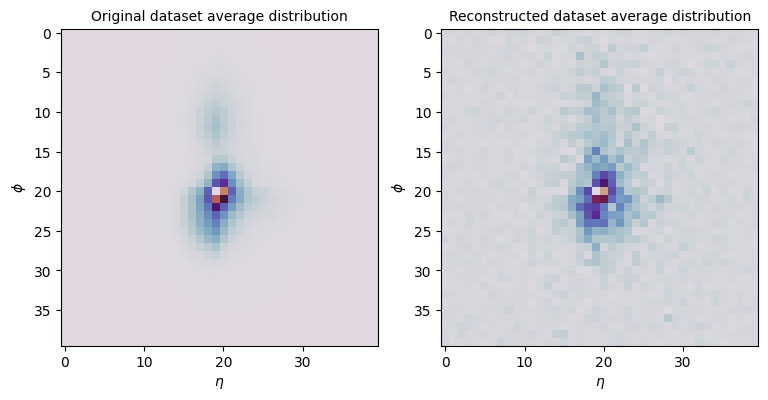

In [14]:
fig, axs = plt.subplots( 1, 2, figsize=(9, 5) )
axs[0].imshow(z_val.mean(0)[0,...], cmap="twilight")
axs[0].set_xlabel( "$\eta$" )
axs[0].set_ylabel( "$\phi$" )
axs[0].set_title(f"Original dataset average distribution", fontsize=10)

axs[1].imshow(pred.mean(0)[0,...], cmap="twilight")
axs[1].set_xlabel( "$\eta$" )
axs[1].set_ylabel( "$\phi$" )
axs[1].set_title(f"Reconstructed dataset average distribution", fontsize=10)

We can see even better how information was removed during the reconstruction process thanks to a plot of the average distribution of the images. 

(d)

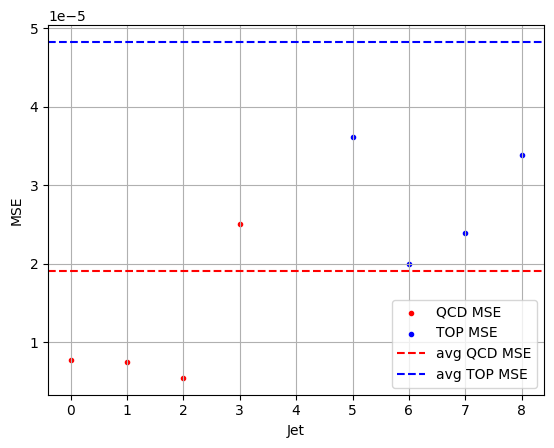

In [16]:
# TODO: Visualize pixel-wise MSE, plot ROC
from sklearn.metrics import mean_squared_error

qcd_mse = []
top_mse = []

for i in range(qcd_jets_original.shape[0]):
    qcd_mse.append(mean_squared_error(qcd_jets_original[i][0], reconstructed_qcd_jets[i][0]))
for i in range(top_jets_original.shape[0]):    
    top_mse.append(mean_squared_error(top_jets_original[i][0], reconstructed_top_jets[i][0]))

average_qcd_mse = np.mean(qcd_mse)
average_top_mse = np.mean(top_mse)

plt.scatter(range(4), qcd_mse[0:4], marker=".", c="red", label="QCD MSE")
plt.scatter(range(5, 9), top_mse[0:4], marker=".", c="blue", label="TOP MSE")

plt.axhline(y=average_qcd_mse, color="red", linestyle="--", label="avg QCD MSE")
plt.axhline(y=average_top_mse, color="blue", linestyle="--", label="avg TOP MSE")


plt.legend()
plt.grid(True)
plt.xlabel("Jet")
plt.ylabel("MSE")
plt.show()

Using the MSE to check the error comparing each image with the reconstructed jet we get (predictably) a higher error for top jets, if compared with QCD jets.<br>
Moreover we thought it could be usefult to show and plot the respective averages, and once again we can show that, on average, the mean squared error computed on the reconstructed images for the QCD jets is lower than the average error for the top jets.

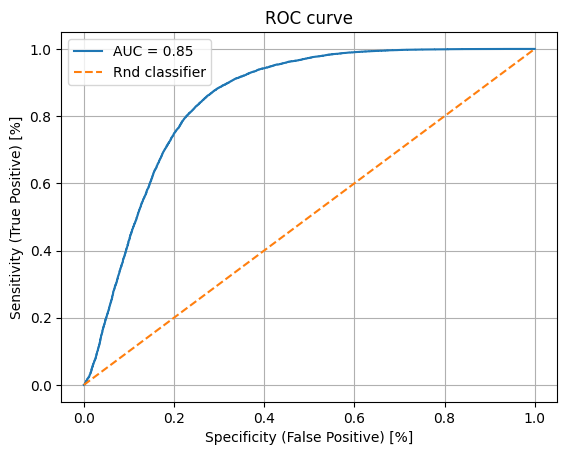

In [17]:
from sklearn.metrics import roc_curve , roc_auc_score

qcd_mse = np.array(qcd_mse)
top_mse = np.array(top_mse)
jets_mse = np.concatenate((qcd_mse,top_mse), axis=None)
jets_mse.size

label_jets = []

for i in range(qcd_mse.size):
    label_jets.append(0)

for i in range(top_mse.size):
    label_jets.append(1)

label_jets = np.array(label_jets)

rnd_class = np.linspace(0, 1, 100)
fpr, tpr, th = roc_curve(label_jets,jets_mse)
auc_score = roc_auc_score(label_jets,jets_mse)
plt.title('ROC curve')
plt.xlabel('Specificity (False Positive) [%]')
plt.ylabel('Sensitivity (True Positive) [%]')
plt.grid()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}' )
plt.plot(rnd_class, rnd_class, '--', label='Rnd classifier')
plt.legend()

A test statistic built in this way performs good in distinguish TOP from QCD jets, as we can see from its AUC score

(e)

In [18]:
# TODO: Repeat everything for CNN
class CNN_Autoencoder(nn.Module):

    def __init__(self):
        super(CNN_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 32, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    

In [19]:
# Preprocess the QCD training data
qcd_train = z_train[ np.where( y_train == 0 ) ]
qcd_train_tensor = torch.tensor( qcd_train.astype( np.float32 ) )


# Generate the QCD training labels (we will not use these but we need them for the dataloader)
qcd_train_labels = y_train[ np.where( y_train == 0 ) ]
qcd_train_labels = torch.Tensor( qcd_train_labels.astype( np.float32 ) ).unsqueeze( -1 )


# Building the dataloader
train_dataset = dataset_manipulator( qcd_train_tensor, qcd_train_labels )
trn_dataloader = torch.utils.data.DataLoader( train_dataset, batch_size=30, shuffle=True )

model = CNN_Autoencoder()
epochs = 10
losses = train_autoencoder( model, trn_dataloader)

100%|██████████| 10/10 [01:17<00:00,  7.79s/it]


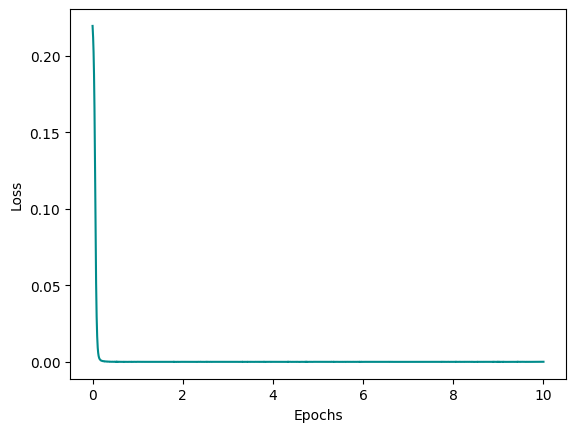

In [20]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( np.linspace(0,epochs,len(losses)),losses, c="darkcyan" )

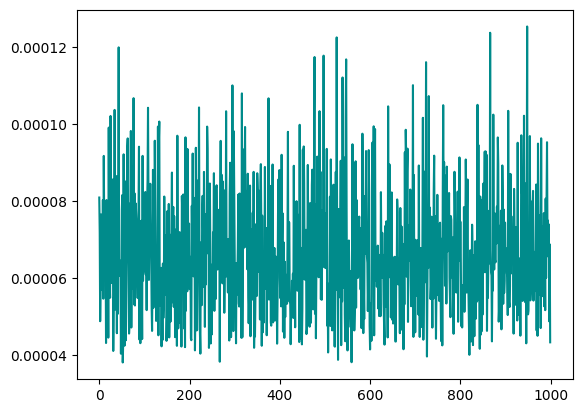

In [23]:
test_jets = torch.tensor(z_test.astype(np.float32))


test_jets_labels = torch.Tensor( y_test.astype(np.float32) ).unsqueeze( -1 )


test_dataset = dataset_manipulator( test_jets, test_jets_labels )
tst_dataloader = torch.utils.data.DataLoader( test_dataset, batch_size=30, shuffle=False )

losses = test_autoencoder(model, tst_dataloader)
plt.plot(losses, c="darkcyan")

In [21]:
top_jets_val = torch.tensor(z_val.astype(np.float32))
top_jets_original = z_val[ np.where(y_val==1) ]
qcd_jets_original = z_val[ np.where(y_val==0) ]

prova = model(top_jets_val)
prova = prova.detach().numpy()

reconstructed_top_jets = prova[ np.where(y_val==1) ]
reconstructed_qcd_jets = prova[ np.where(y_val==0) ]

fig, axs = plt.subplots( 4, 4, figsize=(18,18) )

for i in range(4):
    axs[0, i].imshow( top_jets_original[i][0], cmap="twilight" )
    axs[0, i].set_xlabel( "$\eta$" )
    axs[0, i].set_ylabel( "$\phi$" )
    axs[0, i].set_title(f"Original TOP jet {i}", fontsize=10)

    axs[1, i].imshow( reconstructed_top_jets[i][0], cmap="twilight" )
    axs[1, i].set_xlabel( "$\eta$" )
    axs[1, i].set_ylabel( "$\phi$" )
    axs[1, i].set_title("Corresponding reconstructed TOP jet", fontsize=10)

    axs[2, i].imshow( qcd_jets_original[i][0], cmap="twilight" )
    axs[2, i].set_xlabel( "$\eta$" )
    axs[2, i].set_ylabel( "$\phi$" )
    axs[2, i].set_title(f"Original QCD jet {i}", fontsize=10)

    axs[3, i].imshow( reconstructed_qcd_jets[i][0], cmap="twilight" )
    axs[3, i].set_xlabel( "$\eta$" )
    axs[3, i].set_ylabel( "$\phi$" )
    axs[3, i].set_title("Corresponding reconstructed QCD jet", fontsize=10)

: 

In [ ]:
fig, axs = plt.subplots( 1, 2, figsize=(9, 5) )
axs[0].imshow(z_val.mean(0)[0,...], cmap="twilight")
axs[0].set_xlabel( "$\eta$" )
axs[0].set_ylabel( "$\phi$" )
axs[0].set_title(f"Original dataset average distribution", fontsize=10)

axs[1].imshow(prova.mean(0)[0,...], cmap="twilight")
axs[1].set_xlabel( "$\eta$" )
axs[1].set_ylabel( "$\phi$" )
axs[1].set_title(f"Reconstructed dataset average distribution", fontsize=10)

In [ ]:
# TODO: Visualize pixel-wise MSE, plot ROC
from sklearn.metrics import mean_squared_error

qcd_mse = []
top_mse = []

for i in range(qcd_jets_original.shape[0]):
    qcd_mse.append(mean_squared_error(qcd_jets_original[i][0], reconstructed_qcd_jets[i][0]))
for i in range(top_jets_original.shape[0]):    
    top_mse.append(mean_squared_error(top_jets_original[i][0], reconstructed_top_jets[i][0]))

average_qcd_mse = np.mean(qcd_mse)
average_top_mse = np.mean(top_mse)

plt.scatter(range(4), qcd_mse[0:4], marker=".", c="darkcyan", label="QCD MSE")
plt.scatter(range(5, 9), top_mse[0:4], marker=".", c="skyblue", label="TOP MSE")

plt.axhline(y=average_qcd_mse, color="darkcyan", linestyle="--", label="avg QCD MSE")
plt.axhline(y=average_top_mse, color="skyblue", linestyle="--", label="avg TOP MSE")


plt.legend()
plt.grid(True)
plt.xlabel("Jet")
plt.ylabel("MSE")
plt.show()

In [ ]:
qcd_mse = np.array(qcd_mse)
top_mse = np.array(top_mse)
jets_mse = np.concatenate((qcd_mse,top_mse), axis=None)
jets_mse.size

label_jets = []

for i in range(qcd_mse.size):
    label_jets.append(0)

for i in range(top_mse.size):
    label_jets.append(1)

label_jets = np.array(label_jets)


fpr, tpr, th = roc_curve(label_jets,jets_mse)
plt.title('ROC curve')
plt.xlabel('Specificity (False Positive) [%]')
plt.ylabel('Sensitivity (True Positive) [%]')
plt.grid()
plt.plot(fpr*100, tpr*100, c="darkcyan")

(f)

In [24]:
# TODO: Repeat everything for autoencoder trained on top jets
# You can either use a MLP or a CNN

# Preprocess the top jets training data
top_train = z_train[ np.where( y_train == 1 ) ]
top_train_tensor = torch.tensor( top_train.astype( np.float32 ) )


# Generate the top training labels (we will not use these but we need them for the dataloader)
top_train_labels = y_train[ np.where( y_train == 1 ) ]
top_train_labels = torch.Tensor( top_train_labels.astype( np.float32 ) ).unsqueeze( -1 )


# Building the dataloader
train_dataset = dataset_manipulator( top_train_tensor, top_train_labels )
trn_dataloader = torch.utils.data.DataLoader( train_dataset, batch_size=30, shuffle=True )

model = Autoencoder(20)
epochs = 10
losses = train_autoencoder( model, trn_dataloader)

100%|██████████| 10/10 [00:58<00:00,  5.86s/it]


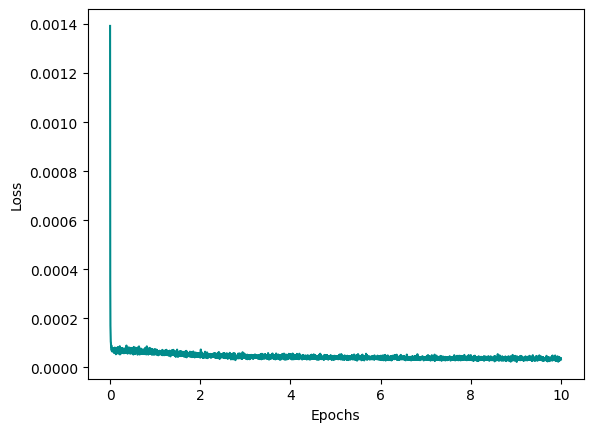

In [25]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( np.linspace(0,epochs,len(losses)),losses, c="darkcyan" )

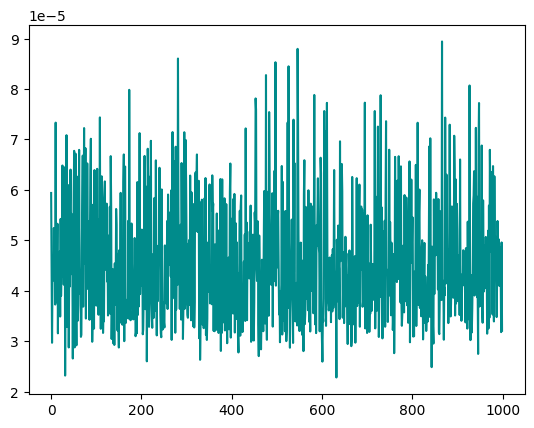

In [26]:
test_jets = torch.tensor(z_test.astype(np.float32))

test_jets_labels = torch.Tensor( y_test.astype(np.float32) ).unsqueeze( -1 )

test_dataset = dataset_manipulator( test_jets, test_jets_labels )
tst_dataloader = torch.utils.data.DataLoader( test_dataset, batch_size=30, shuffle=False )

losses = test_autoencoder(model, tst_dataloader)
plt.plot(losses, c="darkcyan")

Letting the QCD jets be the anomaly makes the performance of the autoencoder model slightly worse. We expect worse reconstructed images

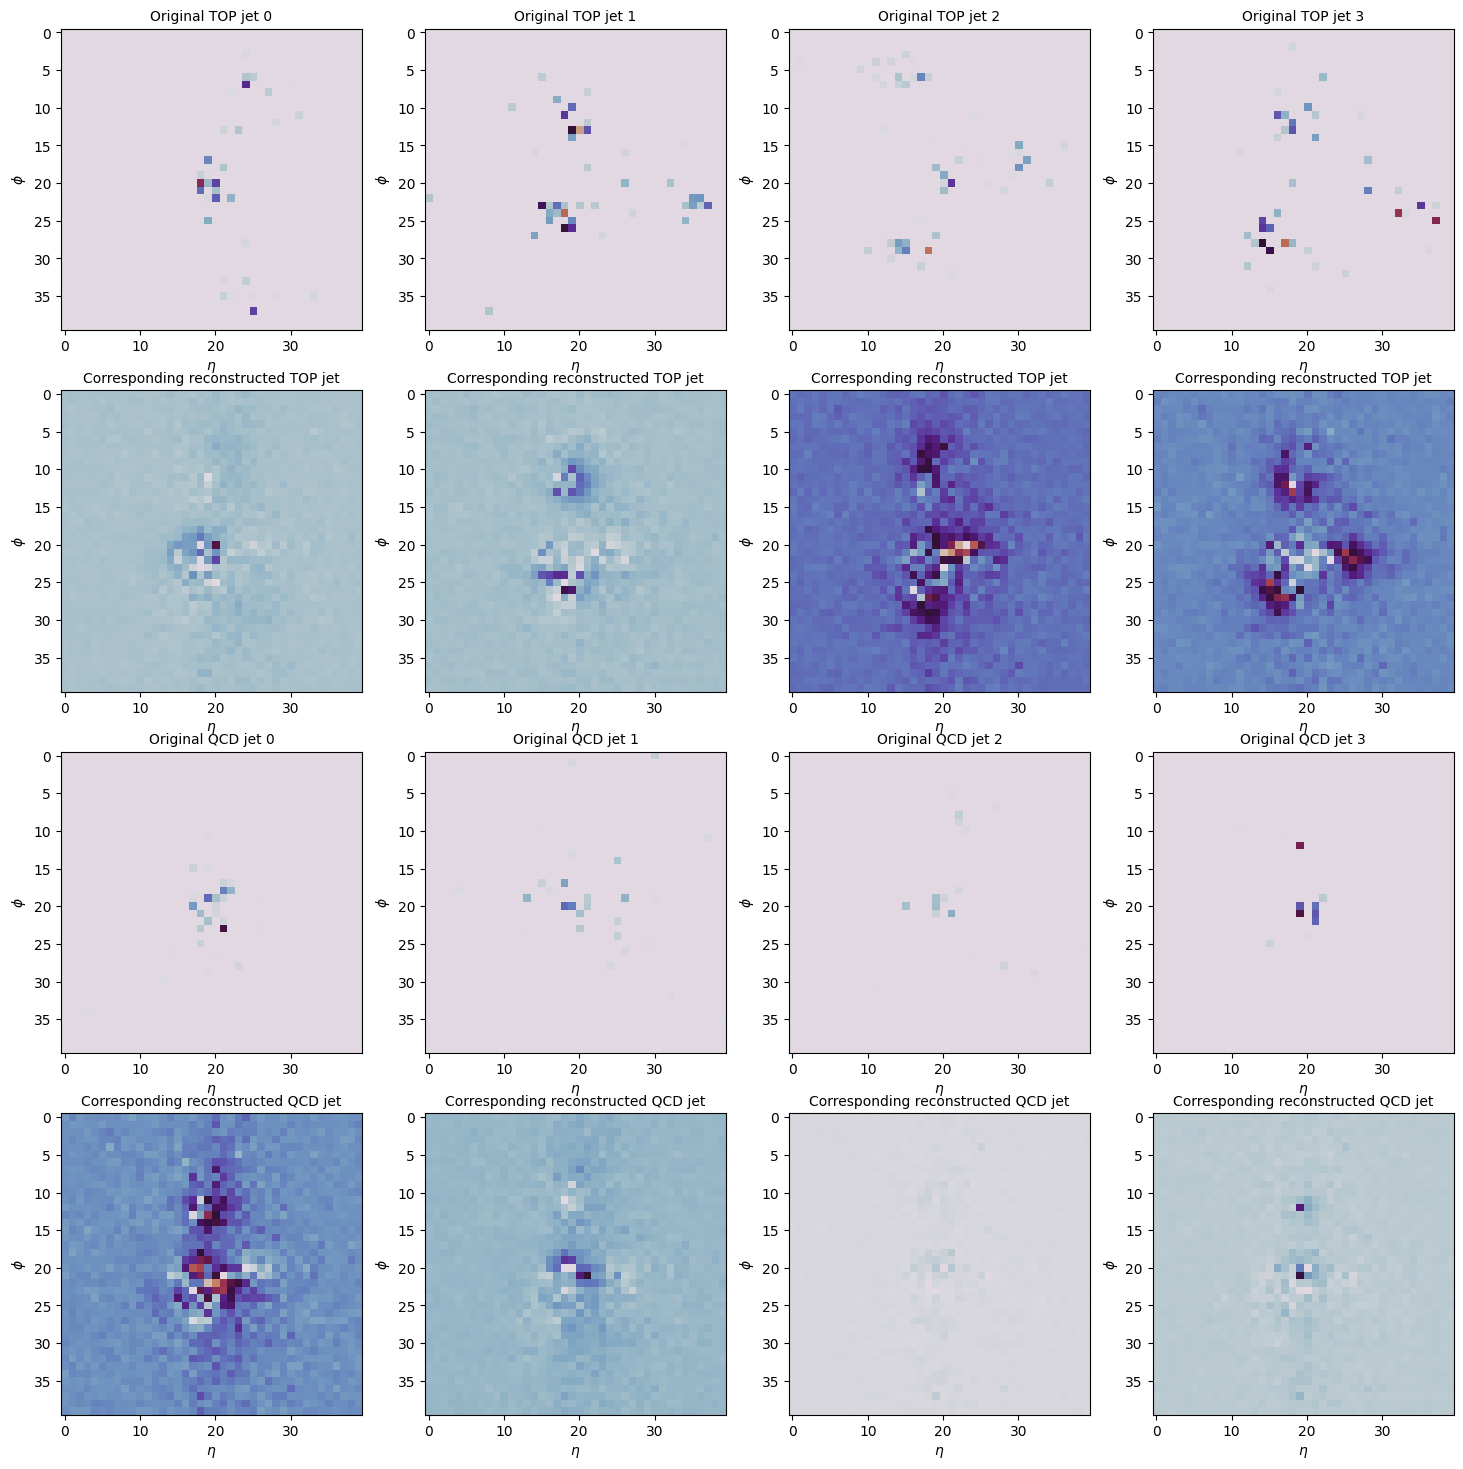

In [27]:
top_jets_val = torch.tensor(z_val.astype(np.float32))
top_jets_original = z_val[ np.where(y_val==1) ]
qcd_jets_original = z_val[ np.where(y_val==0) ]

pred = model(top_jets_val)
pred = pred.detach().numpy()

reconstructed_top_jets = pred[ np.where(y_val==1) ]
reconstructed_qcd_jets = pred[ np.where(y_val==0) ]

fig, axs = plt.subplots( 4, 4, figsize=(18,18) )

for i in range(4):
    axs[0, i].imshow( top_jets_original[i][0], cmap="twilight" )
    axs[0, i].set_xlabel( "$\eta$" )
    axs[0, i].set_ylabel( "$\phi$" )
    axs[0, i].set_title(f"Original TOP jet {i}", fontsize=10)

    axs[1, i].imshow( reconstructed_top_jets[i][0], cmap="twilight" )
    axs[1, i].set_xlabel( "$\eta$" )
    axs[1, i].set_ylabel( "$\phi$" )
    axs[1, i].set_title("Corresponding reconstructed TOP jet", fontsize=10)

    axs[2, i].imshow( qcd_jets_original[i][0], cmap="twilight" )
    axs[2, i].set_xlabel( "$\eta$" )
    axs[2, i].set_ylabel( "$\phi$" )
    axs[2, i].set_title(f"Original QCD jet {i}", fontsize=10)

    axs[3, i].imshow( reconstructed_qcd_jets[i][0], cmap="twilight" )
    axs[3, i].set_xlabel( "$\eta$" )
    axs[3, i].set_ylabel( "$\phi$" )
    axs[3, i].set_title("Corresponding reconstructed QCD jet", fontsize=10)

The quality of the results is comparable with the previos setup. This model is able to show more features of the top jets since their kernels are more clear, but we can see how the amount of noise is higly increased. 

Text(0.5, 1.0, 'Reconstructed dataset average distribution')

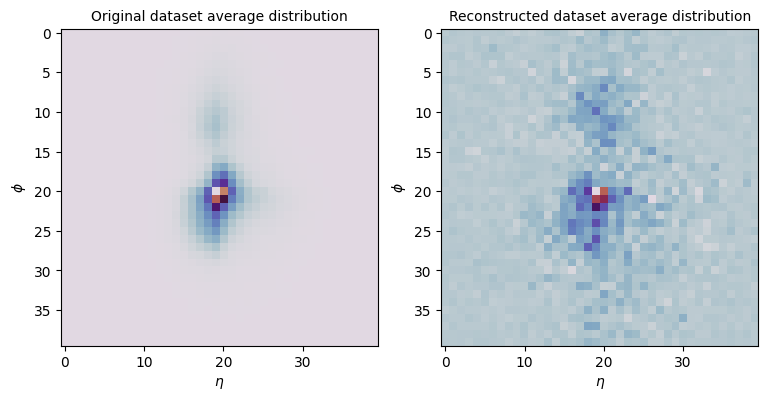

In [28]:
fig, axs = plt.subplots( 1, 2, figsize=(9, 5) )
axs[0].imshow(z_val.mean(0)[0,...], cmap="twilight")
axs[0].set_xlabel( "$\eta$" )
axs[0].set_ylabel( "$\phi$" )
axs[0].set_title(f"Original dataset average distribution", fontsize=10)

axs[1].imshow(pred.mean(0)[0,...], cmap="twilight")
axs[1].set_xlabel( "$\eta$" )
axs[1].set_ylabel( "$\phi$" )
axs[1].set_title(f"Reconstructed dataset average distribution", fontsize=10)

The average distribution of the reconstructed images also suffers from noise, resulting in an overall worse reconstruction respect to the previous setup.

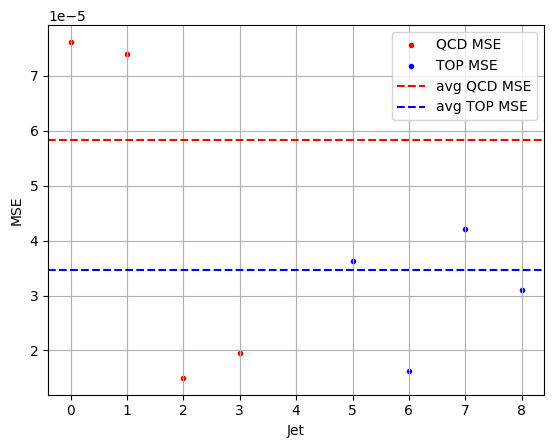

In [29]:
# TODO: Visualize pixel-wise MSE, plot ROC
from sklearn.metrics import mean_squared_error

qcd_mse = []
top_mse = []

for i in range(qcd_jets_original.shape[0]):
    qcd_mse.append(mean_squared_error(qcd_jets_original[i][0], reconstructed_qcd_jets[i][0]))
for i in range(top_jets_original.shape[0]):    
    top_mse.append(mean_squared_error(top_jets_original[i][0], reconstructed_top_jets[i][0]))

average_qcd_mse = np.mean(qcd_mse)
average_top_mse = np.mean(top_mse)

plt.scatter(range(4), qcd_mse[0:4], marker=".", c="red", label="QCD MSE")
plt.scatter(range(5, 9), top_mse[0:4], marker=".", c="blue", label="TOP MSE")

plt.axhline(y=average_qcd_mse, color="red", linestyle="--", label="avg QCD MSE")
plt.axhline(y=average_top_mse, color="blue", linestyle="--", label="avg TOP MSE")


plt.legend()
plt.grid(True)
plt.xlabel("Jet")
plt.ylabel("MSE")
plt.show()

As expected the average value of MSE for TOP jets is lower than for QCD jets, but the results are worse compared to the previous setup

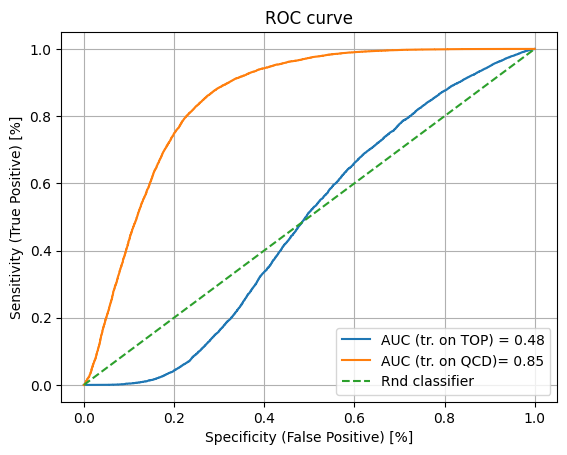

In [30]:
qcd_mse = np.array(qcd_mse)
top_mse = np.array(top_mse)
jets_mse = np.concatenate((qcd_mse,top_mse), axis=None)
jets_mse.size

label_jets = []

for i in range(qcd_mse.size):
    label_jets.append(0)

for i in range(top_mse.size):
    label_jets.append(1)

label_jets = np.array(label_jets)


rnd_class = np.linspace(0, 1, 100)
fpr2, tpr2, th2 = roc_curve(label_jets,jets_mse)
auc_score2 = roc_auc_score(label_jets,jets_mse)
plt.title('ROC curve')
plt.xlabel('Specificity (False Positive) [%]')
plt.ylabel('Sensitivity (True Positive) [%]')
plt.grid()
plt.plot(fpr2, tpr2, label=f'AUC (tr. on TOP) = {auc_score2:.2f}' )
plt.plot(fpr, tpr, label=f'AUC (tr. on QCD)= {auc_score:.2f}' )
plt.plot(rnd_class, rnd_class, '--', label='Rnd classifier')
plt.legend()

A comparison between the ROC curve of the test statistic obtained training the Autoencoder on QCD and TOP jets. The second one is clearly much worse, as we can deduce from its AUC score